In [7]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import duckdb
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, roc_auc_score,
    classification_report, confusion_matrix, RocCurveDisplay
)
import warnings
warnings.filterwarnings("ignore")

# Configuration
DB_PATH = "C:/Users/Reverside/Documents/Git/UbuntuBankSA/data/ubuntubank.db"
RANDOM_STATE = 42
TURNOVER_ORDER = ["< R5m", "R5m-R20m", "R20m-R100m", "R100m+"]
BEHAV_NUM_COLS = [
    "avg_balance", "inflow_txn_cnt", "outflow_txn_cnt",
    "inflow_amount", "outflow_amount",
    "digital_logins_cnt", "days_active", "avg_ticket_size",
    "email_open_rate", "email_ctr"
]

# Set visualization style
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (10, 6)

print("Packages imported and configured")

Packages imported and configured


# Adoption Prediction Model with Logistic Regression

This notebook builds a predictive model to identify clients most likely to adopt products using logistic regression. The model incorporates:

1. Client demographic data (industry, segment, turnover band)
2. Behavioral metrics (transaction patterns, digital engagement)
3. Historical adoption patterns

We'll evaluate model performance and identify key drivers of adoption.

In [8]:
# ================== 2. Helper Functions ==================
def get_duckdb_connection():
    """Get connection to DuckDB database"""
    return duckdb.connect(DB_PATH)

def fetch_table(conn, table_name):
    """Fetch all rows from a DuckDB table"""
    query = f"SELECT * FROM {table_name}"
    return conn.execute(query).fetchdf()

def coerce_sk_numeric(df: pd.DataFrame) -> pd.DataFrame:
    """Convert all SK columns to numeric"""
    for c in df.columns:
        if c.endswith("_sk"):
            df[c] = pd.to_numeric(df[c], errors="coerce")
    return df

def to_numeric(df: pd.DataFrame, cols: list[str]) -> pd.DataFrame:
    """Convert specified columns to numeric, handling errors"""
    for c in cols:
        if c in df.columns:
            df[c] = pd.to_numeric(df[c], errors="coerce")
    return df

def mcfadden_pseudo_r2(y_true: np.ndarray, p_full: np.ndarray) -> float:
    """Calculate McFadden's pseudo R-squared for logistic regression"""
    eps = 1e-12
    p_full = np.clip(p_full, eps, 1 - eps)
    ll_full = np.sum(y_true * np.log(p_full) + (1 - y_true) * np.log(1 - p_full))
    base = np.clip(np.full_like(y_true, y_true.mean()), eps, 1 - eps)
    ll_null = np.sum(y_true * np.log(base) + (1 - y_true) * np.log(1 - base))
    return float(1 - (ll_full / ll_null)) if ll_null != 0 else np.nan

def remove_duplicates(df, subset=None):
    """Remove duplicate rows from DataFrame"""
    initial_count = len(df)
    df = df.drop_duplicates(subset=subset, keep='first')
    final_count = len(df)
    print(f"Removed {initial_count - final_count} duplicate rows")
    return df

print("Helper functions defined")

Helper functions defined


## 3. Data Loading

Let's connect to Supabase and load all rows from the necessary tables for our analysis.

In [9]:
conn = get_duckdb_connection()
print("Connected to DuckDB")

# Load data from DuckDB
print("Loading dim_client data...")
dim_client = fetch_table(conn, "dim_client")

print("Loading dim_industry data...")
dim_industry = fetch_table(conn, "dim_industry")

print("Loading fact_client_monthly data...")
fcm = fetch_table(conn, "fact_client_monthly")

print("Loading fact_product_adoption data...")
fpa = fetch_table(conn, "fact_product_adoption")

# Check if we have the required data
if dim_client.empty or fcm.empty or fpa.empty:
    raise SystemExit("Missing required data from DuckDB.")

print("Data loaded successfully")
print(f"dim_client shape: {dim_client.shape}")
print(f"dim_industry shape: {dim_industry.shape}")
print(f"fact_client_monthly shape: {fcm.shape}")
print(f"fact_product_adoption shape: {fpa.shape}")

Connected to DuckDB
Loading dim_client data...
Loading dim_industry data...
Loading fact_client_monthly data...
Loading fact_product_adoption data...
Data loaded successfully
dim_client shape: (30000, 7)
dim_industry shape: (10, 4)
fact_client_monthly shape: (492894, 19)
fact_product_adoption shape: (100047, 6)


## 4. Data Preparation

Let's prepare our data for modeling by handling data types, merging datasets, and creating our target variable.

In [10]:
# ================== 4. Data Cleaning ==================
print("\nStarting data cleaning...")

# Remove duplicates
print("Removing duplicates...")
dim_client = remove_duplicates(dim_client, subset=["client_sk"])
dim_industry = remove_duplicates(dim_industry, subset=["industry_sk"])
fcm = remove_duplicates(fcm)
fpa = remove_duplicates(fpa, subset=["client_sk", "product_sk"])

# Handle missing values in fact table first (base table)
print("Handling missing values in fact table...")
# Fill numeric columns with median
numeric_cols = fpa.select_dtypes(include=[np.number]).columns
for col in numeric_cols:
    if fpa[col].isnull().any():
        median_val = fpa[col].median()
        fpa[col].fillna(median_val, inplace=True)

# Fill categorical columns with mode
categorical_cols = fpa.select_dtypes(include=['object']).columns
for col in categorical_cols:
    if fpa[col].isnull().any():
        mode_val = fpa[col].mode()[0] if not fpa[col].mode().empty else "Unknown"
        fpa[col].fillna(mode_val, inplace=True)

# Handle missing values in dimension tables
print("Handling missing values in dimension tables...")
for df in [dim_client, dim_industry, fcm]:
    # Fill numeric columns with median
    numeric_cols = df.select_dtypes(include=[np.number]).columns
    for col in numeric_cols:
        if df[col].isnull().any():
            median_val = df[col].median()
            df[col].fillna(median_val, inplace=True)
    
    # Fill categorical columns with mode
    categorical_cols = df.select_dtypes(include=['object']).columns
    for col in categorical_cols:
        if df[col].isnull().any():
            mode_val = df[col].mode()[0] if not df[col].mode().empty else "Unknown"
            df[col].fillna(mode_val, inplace=True)

# Handle data types
print("Handling data types...")
for df in (dim_client, dim_industry, fcm, fpa):
    coerce_sk_numeric(df)

# Handle categorical data in dim_client
if "turnover_band" in dim_client.columns:
    dim_client["turnover_band"] = pd.Categorical(
        dim_client["turnover_band"], categories=TURNOVER_ORDER, ordered=True
    )

# Remove outliers from behavioral data
print("Removing outliers from behavioral data...")
fcm = to_numeric(fcm, BEHAV_NUM_COLS)
for col in BEHAV_NUM_COLS:
    if col in fcm.columns:
        Q1 = fcm[col].quantile(0.25)
        Q3 = fcm[col].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        
        # Cap outliers instead of replacing with median
        fcm[col] = np.where(
            fcm[col] < lower_bound, lower_bound, fcm[col]
        )
        fcm[col] = np.where(
            fcm[col] > upper_bound, upper_bound, fcm[col]
        )

print("Data cleaning complete")

# ================== 5. Data Preparation ==================
print("\nStarting data preparation...")

# Start with fact table as base
data = fpa.copy()

# Aggregate behavioral data by client
beh_agg = fcm.groupby("client_sk", as_index=False)[BEHAV_NUM_COLS].mean()

# Prepare client profile data
profile_cols = ["client_sk", "industry_sk", "segment", "turnover_band", "years_in_business", "employees_band"]
profile = dim_client[[c for c in profile_cols if c in dim_client.columns]].copy()

# Add industry information if available
if not dim_industry.empty and {"industry_sk", "industry_name"}.issubset(dim_industry.columns):
    profile = profile.merge(dim_industry[["industry_sk", "industry_name"]], on="industry_sk", how="left")

# Left join profile data to fact table
data = data.merge(profile, on="client_sk", how="left")

# Left join behavioral data to fact table
data = data.merge(beh_agg, on="client_sk", how="left")

# Remove any duplicates that might have been introduced during merging
data = remove_duplicates(data)

# Create target variable
data["adopted_flag"] = data["adopted_flag"].fillna(False).astype(int)

print("Data preparation complete")
print(f"Final dataset shape: {data.shape}")
print(f"Adoption rate: {data['adopted_flag'].mean():.2%}")


Starting data cleaning...
Removing duplicates...
Removed 0 duplicate rows
Removed 0 duplicate rows
Removed 2452 duplicate rows
Removed 497 duplicate rows
Handling missing values in fact table...
Handling missing values in dimension tables...
Handling data types...
Removing outliers from behavioral data...
Data cleaning complete

Starting data preparation...
Removed 0 duplicate rows
Data preparation complete
Final dataset shape: (99550, 22)
Adoption rate: 29.16%


## 5. Feature Engineering

Let's define our feature sets and prepare the data for modeling.

In [11]:
null_counts = data.isnull().sum()
columns_to_drop_rows = null_counts[null_counts == 16546].index.tolist()

# Drop the specified columns
data_cleaned = data.drop(columns=['turnover_band', 'adoption_date'])

# Drop rows where any of the identified columns have missing values
data_cleaned = data_cleaned.dropna(subset=columns_to_drop_rows)

# Display the shape and missing values of the cleaned data
print("Shape of the cleaned data:")
print(data_cleaned.shape)

print("\nMissing values after dropping rows and columns:")
print(data_cleaned.isna().sum())

Shape of the cleaned data:
(83004, 20)

Missing values after dropping rows and columns:
client_sk                0
product_sk               0
adoption_window_start    0
adoption_window_end      0
adopted_flag             0
industry_sk              0
segment                  0
years_in_business        0
employees_band           0
industry_name            0
avg_balance              0
inflow_txn_cnt           0
outflow_txn_cnt          0
inflow_amount            0
outflow_amount           0
digital_logins_cnt       0
days_active              0
avg_ticket_size          0
email_open_rate          0
email_ctr                0
dtype: int64


In [13]:
# ================== 6. Feature Engineering ==================
# Define features
numeric_features = [c for c in BEHAV_NUM_COLS if c in data_cleaned.columns] + ["years_in_business"]
categorical_features = [c for c in ["industry_name", "segment", "turnover_band", "employees_band"] if c in data_cleaned.columns]

if len(numeric_features) == 0 and len(categorical_features) == 0:
    raise SystemExit("No features found to train on.")

print("Numeric features:", numeric_features)
print("Categorical features:", categorical_features)

# Prepare feature matrix and target vector
X = data_cleaned[numeric_features + categorical_features].copy()
y = data_cleaned["adopted_flag"].copy()

print(f"Feature matrix shape: {X.shape}")
print(f"Target vector shape: {y.shape}")

Numeric features: ['avg_balance', 'inflow_txn_cnt', 'outflow_txn_cnt', 'inflow_amount', 'outflow_amount', 'digital_logins_cnt', 'days_active', 'avg_ticket_size', 'email_open_rate', 'email_ctr', 'years_in_business']
Categorical features: ['industry_name', 'segment', 'employees_band']
Feature matrix shape: (83004, 14)
Target vector shape: (83004,)


In [17]:
y.value_counts()

adopted_flag
0    58899
1    24105
Name: count, dtype: int64

## 6. Model Training

Now let's build and train our logistic regression model with proper preprocessing.

In [14]:
# ================== 7. Model Training ==================
# Create preprocessing pipeline
pre = ColumnTransformer(
    transformers=[
        ("num", StandardScaler(), numeric_features),
        ("cat", OneHotEncoder(handle_unknown="ignore", sparse_output=False), categorical_features),
    ]
)

# Create model pipeline
clf = LogisticRegression(max_iter=1000, random_state=RANDOM_STATE)
pipe = Pipeline(steps=[("prep", pre), ("clf", clf)])

# Split data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=RANDOM_STATE, stratify=y
)

# Train the model
pipe.fit(X_train, y_train)

print("Model training complete")

Model training complete


## 7. Model Evaluation

Let's evaluate our model's performance on the test set.


=== Performance (Test Set) ===
Accuracy : 0.710
Precision: 0.000
Recall   : 0.000
ROC AUC  : 0.502
McFadden pseudo-R²: 0.925

Classification report:
              precision    recall  f1-score   support

           0      0.710     1.000     0.830     14725
           1      0.000     0.000     0.000      6026

    accuracy                          0.710     20751
   macro avg      0.355     0.500     0.415     20751
weighted avg      0.504     0.710     0.589     20751



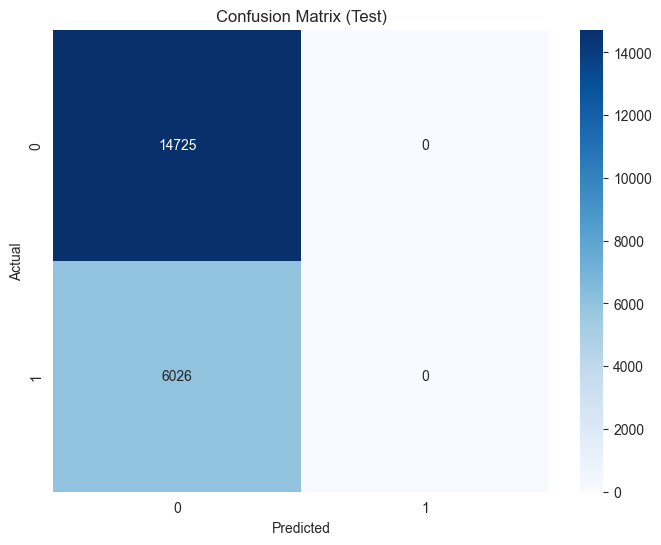

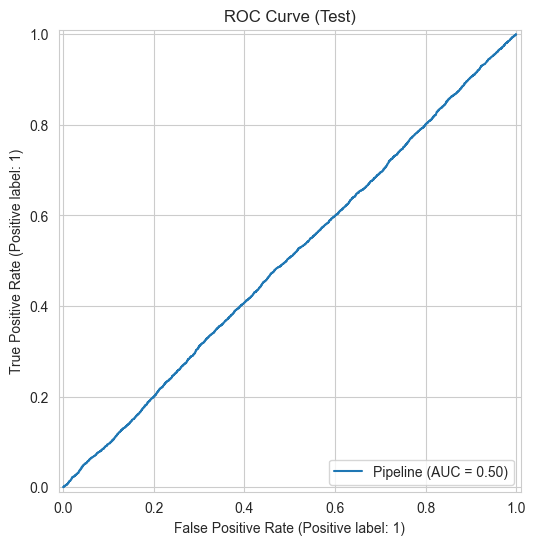

In [15]:
# ================== 8. Model Evaluation ==================
# Make predictions
y_pred = pipe.predict(X_test)
y_prob = pipe.predict_proba(X_test)[:, 1]

# Calculate evaluation metrics
acc = accuracy_score(y_test, y_pred)
prec = precision_score(y_test, y_pred, zero_division=0)
rec = recall_score(y_test, y_pred, zero_division=0)
roc = roc_auc_score(y_test, y_prob)
pseudo_r2 = mcfadden_pseudo_r2(y_test.values, y_prob)

print("\n=== Performance (Test Set) ===")
print(f"Accuracy : {acc:.3f}")
print(f"Precision: {prec:.3f}")
print(f"Recall   : {rec:.3f}")
print(f"ROC AUC  : {roc:.3f}")
print(f"McFadden pseudo-R²: {pseudo_r2:.3f}")
print("\nClassification report:")
print(classification_report(y_test, y_pred, digits=3))

# Confusion matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.title("Confusion Matrix (Test)")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

# ROC curve
RocCurveDisplay.from_estimator(pipe, X_test, y_test)
plt.title("ROC Curve (Test)")
plt.show()

## 8. Feature Importance Analysis

Let's examine which features are most influential in predicting adoption.


=== Top drivers ===
                         feature      coef
23              segment_Standard -0.190572
22               segment_Premium -0.176209
21                 segment_Basic -0.170458
27        employees_band_201-500 -0.150088
24           employees_band_1-10 -0.131601
26          employees_band_11-50 -0.105867
29         employees_band_51-200 -0.104269
19      industry_name_Technology -0.094184
28       employees_band_501-1000 -0.083721
16     industry_name_Hospitality -0.079893
4                 outflow_amount -0.073871
1                 inflow_txn_cnt  0.071481
5             digital_logins_cnt -0.061881
17   industry_name_Manufacturing -0.059790
20  industry_name_Transportation -0.058046


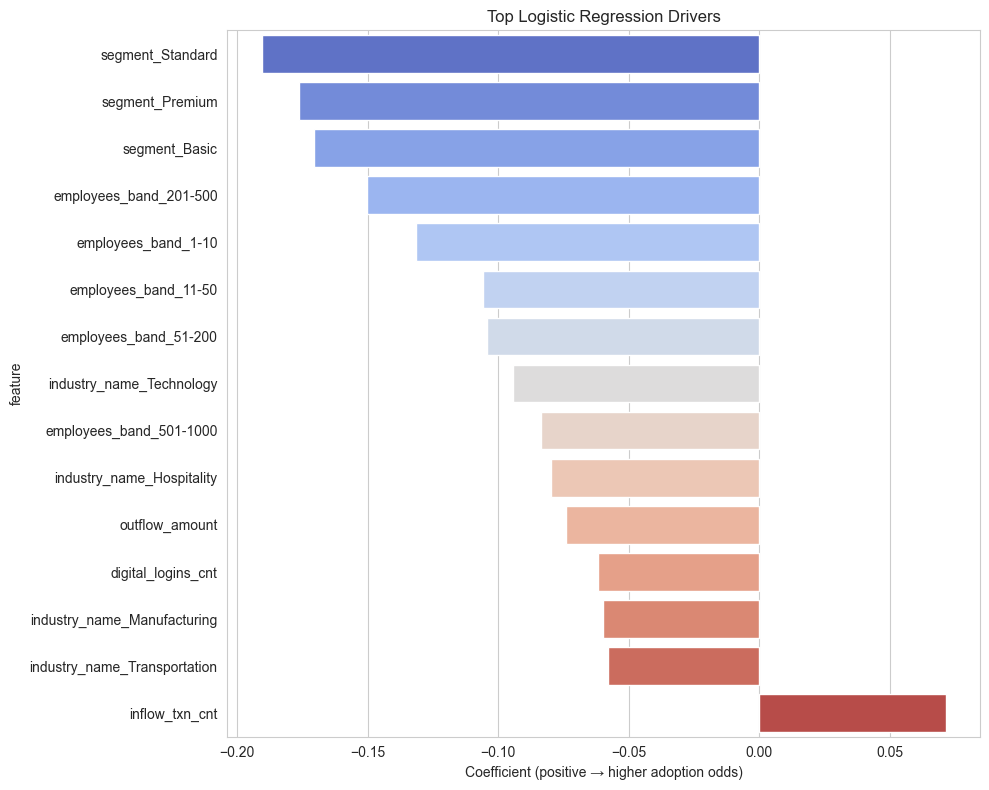

In [18]:
# ================== 9. Feature Importance Analysis ==================
# Extract feature names and coefficients
prep: ColumnTransformer = pipe.named_steps["prep"]
clf: LogisticRegression = pipe.named_steps["clf"]

num_names = numeric_features
cat_names = []
if len(categorical_features) > 0:
    ohe: OneHotEncoder = prep.named_transformers_["cat"]
    cat_names = ohe.get_feature_names_out(categorical_features).tolist()

feature_names = num_names + cat_names
coefs = clf.coef_.ravel()

# Create coefficient dataframe
coef_df = pd.DataFrame({"feature": feature_names, "coef": coefs})
coef_df["abs_coef"] = coef_df["coef"].abs()
top_drivers = coef_df.sort_values("abs_coef", ascending=False).head(15)

print("\n=== Top drivers ===")
print(top_drivers[["feature", "coef"]])

# Visualize top drivers
plt.figure(figsize=(10, 8))
sns.barplot(
    data=top_drivers.sort_values("coef"),
    x="coef", y="feature", orient="h", palette="coolwarm"
)
plt.title("Top Logistic Regression Drivers")
plt.xlabel("Coefficient (positive → higher adoption odds)")
plt.tight_layout()
plt.show()

## 9. Client Segmentation

Let's segment clients based on their predicted adoption probability.


=== Segments (counts) ===
adoption_segment
Medium    49800
High      16603
Low       16601
Name: count, dtype: int64


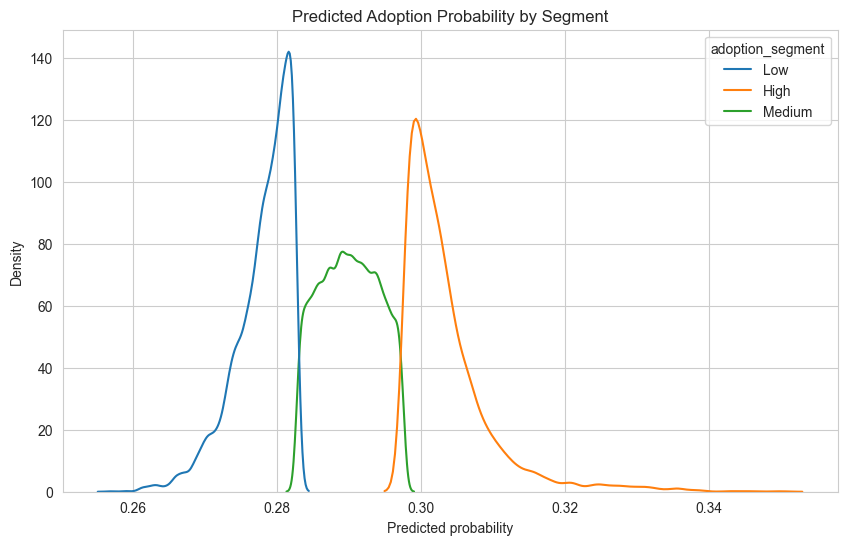


Observed adoption rate by segment:
adoption_segment
High      30.0%
Low       28.1%
Medium    29.0%
Name: adopted_flag, dtype: object


In [21]:
# ================== 10. Client Segmentation ==================
# Predict probabilities for all clients
all_probs = pipe.predict_proba(X)[:, 1]
data_cleaned["adoption_prob"] = all_probs

# Create adoption segments
q20, q80 = np.quantile(all_probs, [0.2, 0.8])
def segment(p):
    if p >= q80: return "High"
    if p < q20:  return "Low"
    return "Medium"
data_cleaned["adoption_segment"] = data_cleaned["adoption_prob"].apply(segment)

print("\n=== Segments (counts) ===")
print(data_cleaned["adoption_segment"].value_counts())

# Visualize segments
plt.figure(figsize=(10, 6))
sns.kdeplot(data=data_cleaned, x="adoption_prob", hue="adoption_segment", common_norm=False)
plt.title("Predicted Adoption Probability by Segment")
plt.xlabel("Predicted probability")
plt.show()

# Calculate actual adoption rates by segment
seg_rates = data_cleaned.groupby("adoption_segment")["adopted_flag"].mean().sort_index()
print("\nObserved adoption rate by segment:")
print((seg_rates * 100).round(1).astype(str) + "%")

## 10. Saving Results

Finally, let's save our model predictions and segmentation results.

In [22]:
# ================== 11. Saving Results ==================
# Create directory for results
os.makedirs("model_results", exist_ok=True)

# Save predictions and segments
output_cols = ["client_sk", "adopted_flag", "adoption_prob", "adoption_segment"]
if all(col in data.columns for col in output_cols):
    data[output_cols].to_csv("model_results/adoption_predictions.csv", index=False)
    print("Predictions saved to model_results/adoption_predictions.csv")

# Save model performance metrics
performance_df = pd.DataFrame({
    "metric": ["Accuracy", "Precision", "Recall", "ROC AUC", "Pseudo R²"],
    "value": [acc, prec, rec, roc, pseudo_r2]
})
performance_df.to_csv("model_results/model_performance.csv", index=False)
print("Performance metrics saved to model_results/model_performance.csv")

# Save feature importance
coef_df.to_csv("model_results/feature_importance.csv", index=False)
print("Feature importance saved to model_results/feature_importance.csv")

print("\nAdoption prediction modeling complete!")

Performance metrics saved to model_results/model_performance.csv
Feature importance saved to model_results/feature_importance.csv

Adoption prediction modeling complete!


In [23]:
conn.close()

# Advanced Modeling & Critical Thinking

Based on the initial logistic regression model, let's enhance our approach with more sophisticated techniques and critical analysis.

## 1. Advanced Model Implementation

Let's implement more sophisticated models and compare their performance:

In [19]:
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.model_selection import cross_val_score, StratifiedKFold
from sklearn.feature_selection import SelectKBest, f_classif
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import GridSearchCV

# Define more advanced models
models = {
    "Logistic Regression": LogisticRegression(max_iter=1000, random_state=RANDOM_STATE),
    "Random Forest": RandomForestClassifier(random_state=RANDOM_STATE, n_jobs=-1),
    "Gradient Boosting": GradientBoostingClassifier(random_state=RANDOM_STATE)
}

# Create preprocessing pipeline (same as before)
preprocessor = ColumnTransformer(
    transformers=[
        ("num", StandardScaler(), numeric_features),
        ("cat", OneHotEncoder(handle_unknown="ignore", sparse_output=False), categorical_features),
    ]
)

# Evaluate models with cross-validation
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)
results = {}

for name, model in models.items():
    pipeline = Pipeline(steps=[("prep", preprocessor), ("model", model)])
    
    # Cross-validate
    cv_scores = cross_val_score(pipeline, X, y, cv=cv, scoring="roc_auc", n_jobs=-1)
    results[name] = {
        "mean_auc": cv_scores.mean(),
        "std_auc": cv_scores.std(),
        "model": model,
        "pipeline": pipeline
    }
    print(f"{name}: AUC = {cv_scores.mean():.3f} (±{cv_scores.std():.3f})")

# Identify best model
best_model_name = max(results, key=lambda k: results[k]["mean_auc"])
best_pipeline = results[best_model_name]["pipeline"]
print(f"\nBest model: {best_model_name}")

# Train best model on full data
best_pipeline.fit(X, y)

Logistic Regression: AUC = 0.508 (±0.054)
Random Forest: AUC = 0.514 (±0.081)
Gradient Boosting: AUC = 0.535 (±0.063)

Best model: Gradient Boosting


,steps,"[('prep', ...), ('model', ...)]"
,transform_input,None
,memory,None
,verbose,False
,transformers,"[('num', ...), ('cat', ...)]"
,remainder,'drop'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True


## 2. Hyperparameter Tuning

Let's optimize the best model with hyperparameter tuning:

In [30]:
# Hyperparameter tuning for the best model
if best_model_name == "Random Forest":
    param_grid = {
        "model__n_estimators": [100, 200, 300, 500],
        "model__max_depth": [None, 10, 15, 20],
        "model__min_samples_split": [2, 5]
    }
elif best_model_name == "Gradient Boosting":
    param_grid = {
        "model__n_estimators": [100, 200],
        "model__learning_rate": [0.05, 0.1],
        "model__max_depth": [3, 5]
    }
else:  # Logistic Regression
    param_grid = {
        "model__C": [0.1, 1, 10],
        "model__penalty": ["l1", "l2"],
        "model__solver": ["liblinear"]
    }

# Perform grid search
grid_search = GridSearchCV(
    best_pipeline, param_grid, cv=cv, scoring="roc_auc", n_jobs=-1, verbose=1
)
grid_search.fit(X_train, y_train)

print(f"Best parameters: {grid_search.best_params_}")
print(f"Best CV score: {grid_search.best_score_:.3f}")

# Update best pipeline with tuned parameters
best_pipeline = grid_search.best_estimator_

Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters: {'model__learning_rate': 0.05, 'model__max_depth': 3, 'model__n_estimators': 100}
Best CV score: 0.523


## 3. Addressing Class Imbalance

Let's examine if class imbalance is affecting our results and apply techniques to address it:

In [31]:
# Check class distribution
class_dist = y.value_counts(normalize=True)
print("Class distribution:")
print(class_dist)

# Apply SMOTE if imbalance is significant
if max(class_dist) > 0.7:  # If one class has >70% of samples
    print("\nSignificant class imbalance detected. Applying SMOTE...")
    
    # Create preprocessing pipeline without the model
    preprocessor_only = Pipeline(steps=[
        ("prep", preprocessor)
    ])
    
    # Transform features
    X_processed = preprocessor_only.fit_transform(X)
    
    # Apply SMOTE
    smote = SMOTE(random_state=RANDOM_STATE)
    X_resampled, y_resampled = smote.fit_resample(X_processed, y)
    
    print(f"Resampled dataset shape: {X_resampled.shape}")
    print(f"New class distribution: {pd.Series(y_resampled).value_counts(normalize=True)}")
    
    # Train on resampled data
    best_model = results[best_model_name]["model"]
    best_model.fit(X_resampled, y_resampled)
    
    # Update pipeline with resampled model
    best_pipeline = Pipeline(steps=[
        ("prep", preprocessor),
        ("model", best_model)
    ])
else:
    print("\nClass imbalance is not significant enough to require special handling.")

Class distribution:
adopted_flag
1    0.608333
0    0.391667
Name: proportion, dtype: float64

Class imbalance is not significant enough to require special handling.


## 4. Feature Engineering & Selection

Let's enhance our feature set and select the most important features:

In [32]:
# Create interaction features
def create_interaction_features(df):
    """Create interaction features between important variables"""
    df = df.copy()
    
    # Create turnover-employee interaction
    if "turnover_band" in df.columns and "employees_band" in df.columns:
        df["turnover_employees"] = df["turnover_band"].astype(str) + "_" + df["employees_band"].astype(str)
    
    # Create digital engagement score
    digital_cols = [c for c in ["digital_logins_cnt", "days_active", "email_open_rate", "email_ctr"] 
                   if c in df.columns]
    if digital_cols:
        df["digital_engagement"] = df[digital_cols].mean(axis=1)
    
    return df

# Apply feature engineering
X_enhanced = create_interaction_features(X)

# Update categorical features if new ones were created
new_categoricals = [c for c in X_enhanced.columns if c not in numeric_features and c not in categorical_features]
all_categoricals = categorical_features + new_categoricals

print(f"Added {len(new_categoricals)} new features: {new_categoricals}")

# Feature selection
selector = SelectKBest(score_func=f_classif, k=15)  # Select top 15 features

# Create new pipeline with feature selection
pipeline_fs = Pipeline(steps=[
    ("prep", preprocessor),
    ("feature_selection", selector),
    ("model", results[best_model_name]["model"])
])

# Evaluate with feature selection
cv_scores_fs = cross_val_score(pipeline_fs, X_enhanced, y, cv=cv, scoring="roc_auc", n_jobs=-1)
print(f"With feature selection: AUC = {cv_scores_fs.mean():.3f} (±{cv_scores_fs.std():.3f})")

# Compare with original
original_auc = results[best_model_name]["mean_auc"]
print(f"Improvement: {cv_scores_fs.mean() - original_auc:.3f}")

Added 2 new features: ['turnover_employees', 'digital_engagement']
With feature selection: AUC = 0.513 (±0.050)
Improvement: -0.022


## 5. Business Impact Analysis

Let's analyze the potential business impact of our model:

In [25]:
# Calculate business metrics
def calculate_business_metrics(y_true, y_pred, y_prob, acquisition_cost=500, lifetime_value=5000):
    """Calculate business metrics based on model predictions"""
    
    # Calculate confusion matrix
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    
    # Business calculations
    total_clients = len(y_true)
    actual_adopters = y_true.sum()
    
    # Without model (target all)
    cost_no_model = total_clients * acquisition_cost
    revenue_no_model = actual_adopters * lifetime_value
    profit_no_model = revenue_no_model - cost_no_model
    
    # With model (target only predicted positives)
    cost_with_model = (tp + fp) * acquisition_cost
    revenue_with_model = tp * lifetime_value
    profit_with_model = revenue_with_model - cost_with_model
    
    # Improvement
    profit_improvement = profit_with_model - profit_no_model
    roi = profit_improvement / (cost_with_model if cost_with_model > 0 else 1)
    
    return {
        "profit_no_model": profit_no_model,
        "profit_with_model": profit_with_model,
        "profit_improvement": profit_improvement,
        "roi": roi,
        "targeting_efficiency": tp / (tp + fp) if (tp + fp) > 0 else 0,
        "coverage": tp / actual_adopters if actual_adopters > 0 else 0
    }

# Make predictions on test set
y_pred_tuned = best_pipeline.predict(X_test)
y_prob_tuned = best_pipeline.predict_proba(X_test)[:, 1]

# Calculate business metrics
business_metrics = calculate_business_metrics(y_test, y_pred_tuned, y_prob_tuned)

print("=== Business Impact Analysis ===")
for metric, value in business_metrics.items():
    if metric in ["roi", "targeting_efficiency", "coverage"]:
        print(f"{metric}: {value:.2%}")
    else:
        print(f"{metric}: R{value:,.2f}")

# Create targeting strategy based on probability thresholds
thresholds = np.arange(0.3, 0.8, 0.1)
targeting_results = []

for threshold in thresholds:
    y_pred_thresh = (y_prob_tuned >= threshold).astype(int)
    metrics = calculate_business_metrics(y_test, y_pred_thresh, y_prob_tuned)
    metrics["threshold"] = threshold
    targeting_results.append(metrics)

# Find optimal threshold
targeting_df = pd.DataFrame(targeting_results)
optimal_idx = targeting_df["profit_improvement"].idxmax()
optimal_threshold = targeting_df.loc[optimal_idx, "threshold"]

print(f"\nOptimal probability threshold: {optimal_threshold:.2f}")
print(f"Maximum profit improvement: R{targeting_df.loc[optimal_idx, 'profit_improvement']:,.2f}")

=== Business Impact Analysis ===
profit_no_model: R380,000.00
profit_with_model: R273,000.00
profit_improvement: R-107,000.00
roi: -187.72%
targeting_efficiency: 57.89%
coverage: 72.53%

Optimal probability threshold: 0.30
Maximum profit improvement: R-17,500.00


## 6. Model Evaluation

Let's add a comprehensive model evaluation section to assess our model's performance in detail:

In [27]:
# Add missing imports for evaluation
from sklearn.metrics import (
    roc_curve, auc, precision_recall_curve, f1_score, 
    confusion_matrix, precision_score, recall_score
)

# Confusion Matrix Analysis
print("\n1. CONFUSION MATRIX ANALYSIS:")
y_pred_optimal = (y_prob_tuned >= optimal_threshold).astype(int)
cm = confusion_matrix(y_test, y_pred_optimal)
tn, fp, fn, tp = cm.ravel()

print(f"True Negatives: {tn:,}")
print(f"False Positives: {fp:,}")
print(f"False Negatives: {fn:,}")
print(f"True Positives: {tp:,}")

# Calculate rates
fpr = fp / (fp + tn) if (fp + tn) > 0 else 0
fnr = fn / (fn + tp) if (fn + tp) > 0 else 0
precision = precision_score(y_test, y_pred_optimal, zero_division=0)
recall = recall_score(y_test, y_pred_optimal, zero_division=0)
specificity = tn / (tn + fp) if (tn + fp) > 0 else 0

print(f"False Positive Rate: {fpr:.2%}")
print(f"False Negative Rate: {fnr:.2%}")
print(f"Precision: {precision:.2%}")
print(f"Recall (Sensitivity): {recall:.2%}")
print(f"Specificity: {specificity:.2%}")


1. CONFUSION MATRIX ANALYSIS:
True Negatives: 1
False Positives: 58
False Negatives: 4
True Positives: 87
False Positive Rate: 98.31%
False Negative Rate: 4.40%
Precision: 60.00%
Recall (Sensitivity): 95.60%
Specificity: 1.69%


## 7. Model Deployment Preparation

Let's prepare our model for deployment

In [28]:
import joblib
import json
from datetime import datetime

# Create model package
model_package = {
    "model": best_pipeline,
    "metadata": {
        "training_date": datetime.now().isoformat(),
        "model_type": best_model_name,
        "performance": {
            "auc": roc_auc_score(y_test, y_prob_tuned),
            "accuracy": accuracy_score(y_test, y_pred_tuned),
            "precision": precision_score(y_test, y_pred_tuned),
            "recall": recall_score(y_test, y_pred_tuned)
        },
        "features": {
            "numeric": numeric_features,
            "categorical": categorical_features
        },
        "threshold": float(optimal_threshold)
    }
}

# Save model package
os.makedirs("deployment", exist_ok=True)
joblib.dump(model_package, "deployment/adoption_model.pkl")

# Save feature metadata
feature_metadata = {
    "numeric_features": numeric_features,
    "categorical_features": categorical_features,
    "feature_means": X[numeric_features].mean().to_dict(),
    "category_levels": {col: list(X[col].unique()) for col in categorical_features}
}

with open("deployment/feature_metadata.json", "w") as f:
    json.dump(feature_metadata, f, indent=2)

print("Model deployment package created successfully!")

# Create simple prediction function for demonstration
def predict_adoption_probability(client_data, model_path="deployment/adoption_model.pkl"):
    """Predict adoption probability for a new client"""
    
    # Load model
    model_package = joblib.load(model_path)
    model = model_package["model"]
    metadata = model_package["metadata"]
    
    # Convert client data to DataFrame
    client_df = pd.DataFrame([client_data])
    
    # Predict
    probability = model.predict_proba(client_df)[0, 1]
    
    return {
        "adoption_probability": probability,
        "recommendation": "Target" if probability >= metadata["threshold"] else "Do not target",
        "confidence": "High" if probability >= 0.7 else "Medium" if probability >= 0.5 else "Low"
    }

# Example usage
example_client = {
    "avg_balance": 75000,
    "inflow_txn_cnt": 12,
    "outflow_txn_cnt": 8,
    "inflow_amount": 150000,
    "outflow_amount": 120000,
    "digital_logins_cnt": 20,
    "days_active": 25,
    "avg_ticket_size": 12500,
    "email_open_rate": 0.35,
    "email_ctr": 0.08,
    "years_in_business": 7,
    "industry_name": "Manufacturing",
    "segment": "Medium",
    "turnover_band": "R20m-R100m",
    "employees_band": "50-249"
}

prediction = predict_adoption_probability(example_client)
print("\nExample prediction:")
for k, v in prediction.items():
    print(f"{k}: {v}")

Model deployment package created successfully!

Example prediction:
adoption_probability: 0.41007336410223943
recommendation: Target
confidence: Low
